## Get data

In [ ]:
!gdown 1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2

Downloading...
From: https://drive.google.com/uc?id=1UxKrIt_NlstgXnIbAcSr1vwHlVMPfRF2
To: /content/recordings.tgz
100% 465M/465M [00:02<00:00, 209MB/s]


untar file

In [ ]:
!tar -xzvf /content/recordings.tgz

get xls file with description for each audio file

In [ ]:
!gdown 1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde

Downloading...
From: https://drive.google.com/uc?id=1UNh9fROnTopHQIbZIEcTZW2FUJQWLhde
To: /content/recordings_emmanouela.xlsx
100% 26.7k/26.7k [00:00<00:00, 34.2MB/s]


## Set up environment and functions

module for Amplitude Modulation Analysis

In [ ]:
!git clone https://github.com/MuSAELab/amplitude-modulation-analysis-module.git

Cloning into 'amplitude-modulation-analysis-module'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 143 (delta 0), reused 1 (delta 0), pack-reused 140
Receiving objects: 100% (143/143), 785.74 KiB | 10.76 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [200]:
!pip install /content/amplitude-modulation-analysis-module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./amplitude-modulation-analysis-module
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for am-analysis: filename=am_analysis-0.1-py3-none-any.whl size=20037 sha256=94f13d281635cb376187686b0e9274b6ab00b807b7000396dfc73d277ed62903
  Stored in directory: /root/.cache/pip/wheels/aa/76/b8/2732d7b7c13056fe54c9e5d5ca19ce86a8c474ad499eec0e14
Successfully built am-analysis
  Attempting uninstall: am-analysis
    Found existing installation: am-analysis 0.1
    Uninstalling am-analysis-0.1:
      Successfully uninstalled am-analys

### import useful stuff

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import hilbert, butter, lfilter, freqz
from scipy import signal as sig
import pandas as pd
from IPython.display import Audio
import librosa
import librosa.display
import IPython.display as ipd

import os

from am_analysis import am_analysis as ama

### create bandpass (Butterworth) filter

In [364]:

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



### another bandpass filter using *FIR*

In [417]:

def bandpass(input, fs, fpl, fph, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a bandpass filter.
        fs : sampling frequency (Hz)
        fpl : low pass frequency (Hz)
        fph : high pass frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, [fpl / (fs * 0.5), fph / (fs * 0.5)], window=('kaiser', beta),pass_zero='bandpass')

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### lowpass filter

In [391]:
def lowpass(input, fs, fc, bandwidth, ripple_db=65.0):
        """
        Designs a FIR filter that is a low-pass filter.
        fs : sampling frequency (Hz)
        fc : cut-off frequency (Hz)
        bandwidth : transition bandwidth (Hz)s
        """
        # Compute the order and Kaiser parameter for the FIR filter.
        N, beta = sig.kaiserord(ripple_db, bandwidth / (fs * 0.5) )

        # Use firwin with a Kaiser window to create a lowpass FIR filter.
        taps = sig.firwin(N, fc / (fs * 0.5), window=('kaiser', beta))

        # the filter must be symmetric, in order to be zero-phase
        assert np.all(np.abs(taps - taps[::-1]) < 1e-15)

        input_filt = sig.filtfilt(taps, 1, input)

        return input_filt

### bandstop (notch) filter

In [421]:
def bandstop(input,fs, fstop, quality_factor=30):
    """
    Designs a IIR bandstop filter.
    fs : sampling frequency (Hz)
    fstop : frequency to remove (Hz)
    quality_factor : dimensionless parameter that characterises quality
    """
    b_notch, a_notch = sig.iirnotch(fstop, quality_factor, fs)
    input_notched = sig.filtfilt(b_notch, a_notch, input)
    return input


## choose a signal to work on

In [202]:

df = pd.read_excel('recordings_emmanouela.xlsx')

display(df)

file_name                species  \
0                  LT07 two barbets 17102009  Black-collared Barbet   
1                    LT12 4 barbets 31202009  Black-collared Barbet   
2                 LT38 four barbets 15112010  Black-collared Barbet   
3                                111113_0028  Black-collared Barbet   
4             LT35_barbethatchling_05112011a  Black-collared Barbet   
..                                       ...                    ...   
79         MP023 honeyguide begging 27102008     Greater Honeyguide   
80  MP024 pipping honeyguide part A 24102008     Greater Honeyguide   
81  MP024 pipping honeyguide part B 24102008     Greater Honeyguide   
82         MP028 honeyguide begging 25102008     Greater Honeyguide   
83         MP053 honeyguide begging 07112008     Greater Honeyguide   

    individuals chick stage              type  
0             2     stage 4       host1_brood  
1             4         NaN       host1_brood  
2             4     stage 4       host1_brood  
3             1     stage 1      host1_single  
4             1     stage 1      host1_single  
..          ...         ...               ...  
79            1     stage 2  parasite2_single  
80            1     stage 2  parasite2_single  
81            1     stage 0  parasite2_single  
82            1     stage 0  parasite2_single  
83            1     stage 4  parasite2_single  

[84 rows x 5 columns]

In [ ]:
!ls /content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav

In [203]:
audiofile = '/content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav'

total audio duration of file /content/recordings/parasite1_single/LT11_honeyguide_begging_28102010.wav is : 44.46s


[]

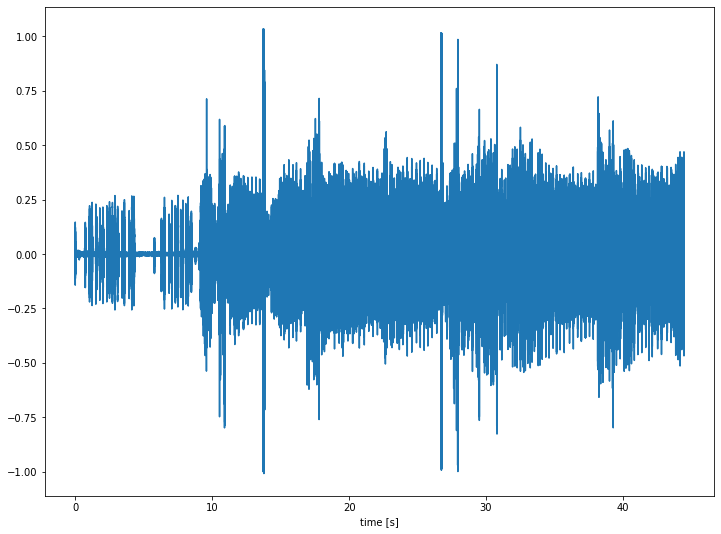

In [204]:
signal_full, sr = librosa.load(audiofile)
print(f'total audio duration of file {audiofile} is : {len(signal_full)/sr:.2f}s')

t = np.linspace(0,len(signal_full)/sr, len(signal_full))
plt.figure(figsize=(12,9))
plt.plot(t, signal_full)
plt.xlabel('time [s]')
plt.plot()

[]

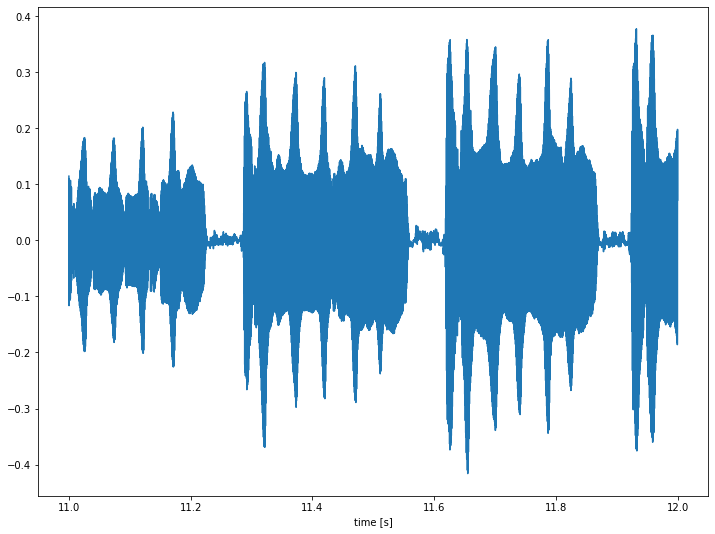

In [303]:
# choose a clip of the full audio file.
# start at signal_start seconds
# and get a clip of duration signal_duration seconds
signal_start = 11
signal_duration = 1

signal = signal_full[signal_start*sr:(signal_start + signal_duration)*sr]

t = np.linspace(signal_start,signal_start+signal_duration, len(signal))
plt.figure(figsize=(12,9))
plt.plot(t, signal)
plt.xlabel('time [s]')
plt.plot()

## Modulation Spectrogram of original signal

Plot the modulation spectrograms of the full or clipped audio file

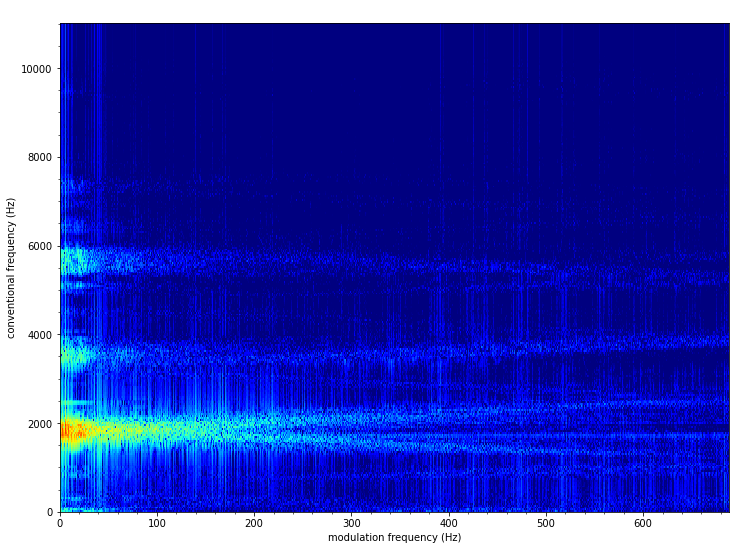

In [363]:

window_size = 512
window_shift = 16

#choose signal_full or signal as input
ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


plt.figure(figsize=(12,9))
ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])
plt.show()

## Filter bank original signal

create freqyency bands for the filter bank

In [424]:
freq_range = [100,10400]
freqs = np.linspace(freq_range[0],freq_range[1],16)


apply bandpass filter and plot results

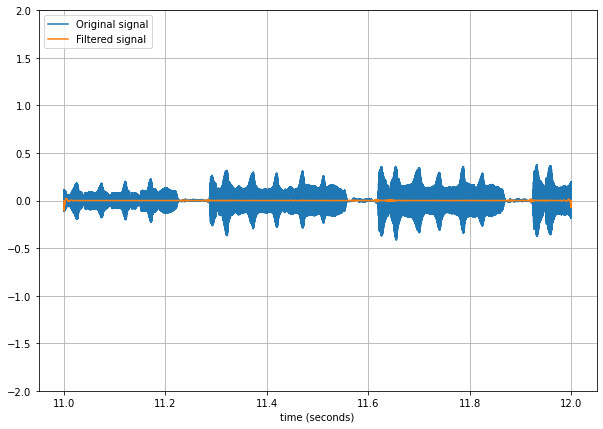

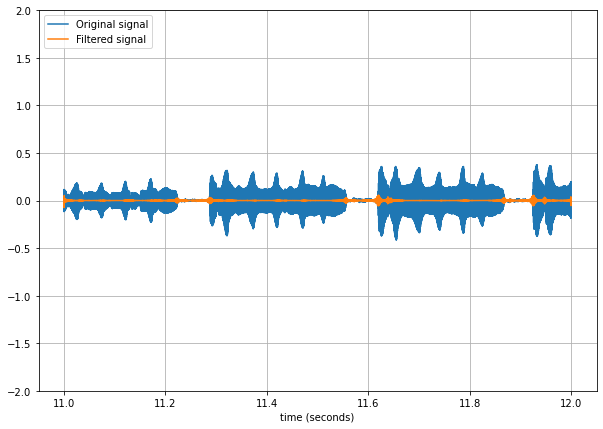

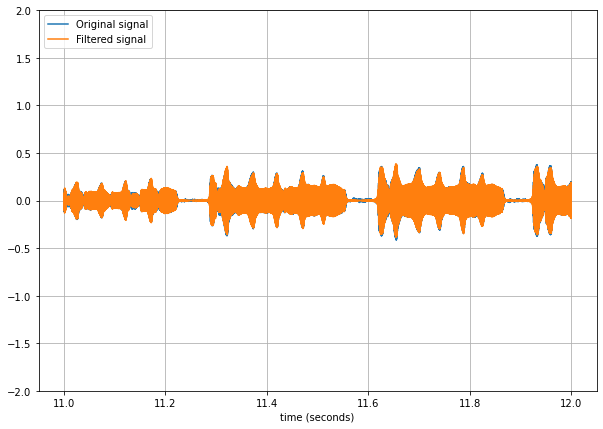

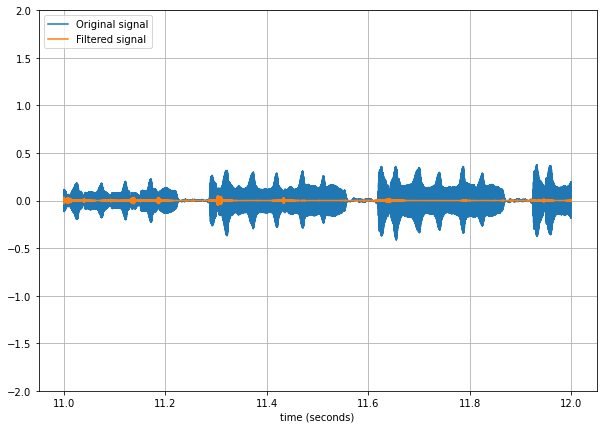

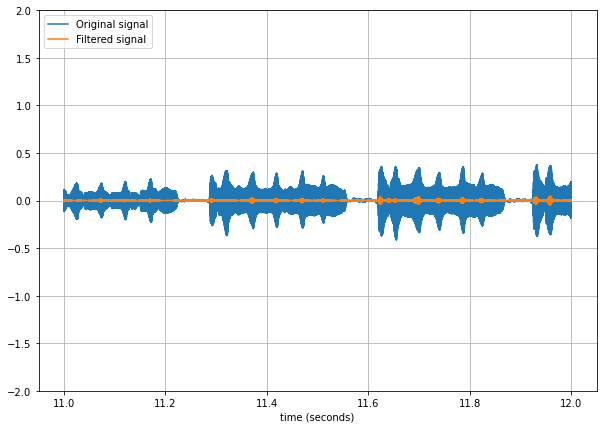

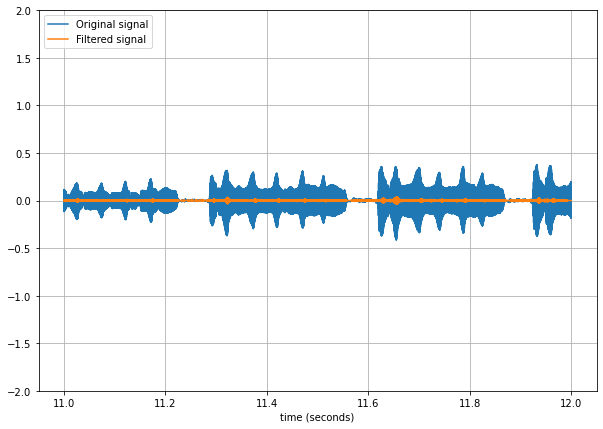

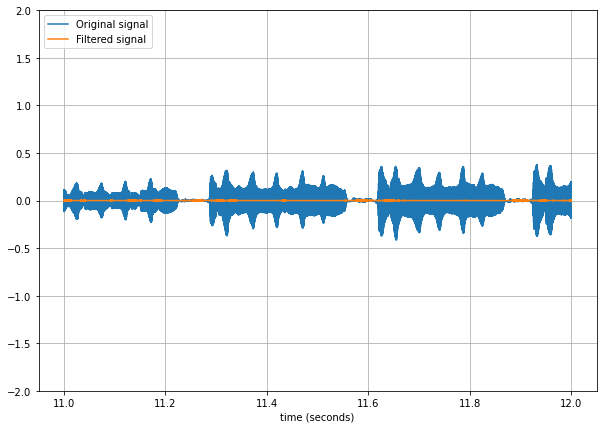

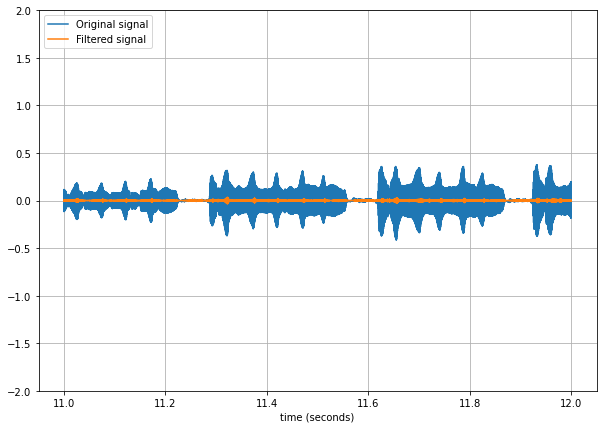

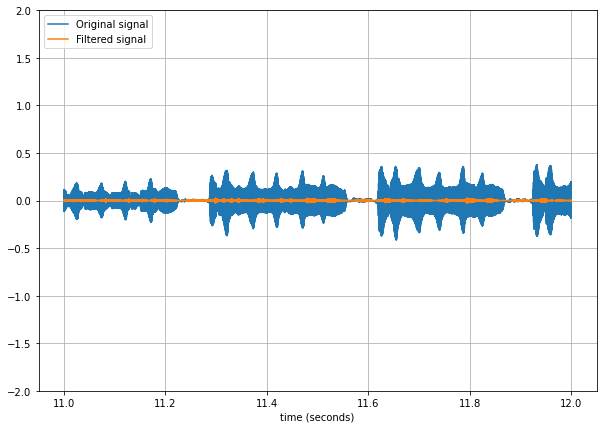

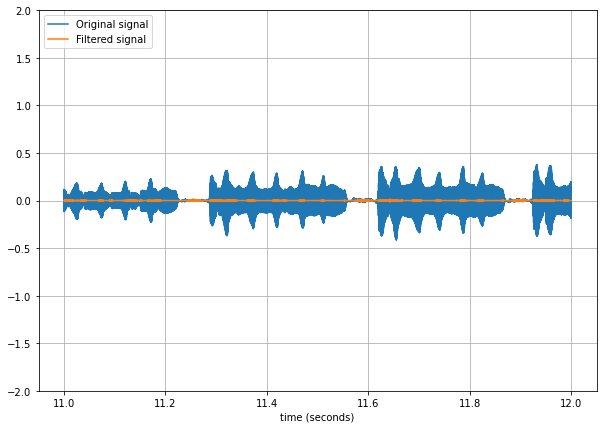

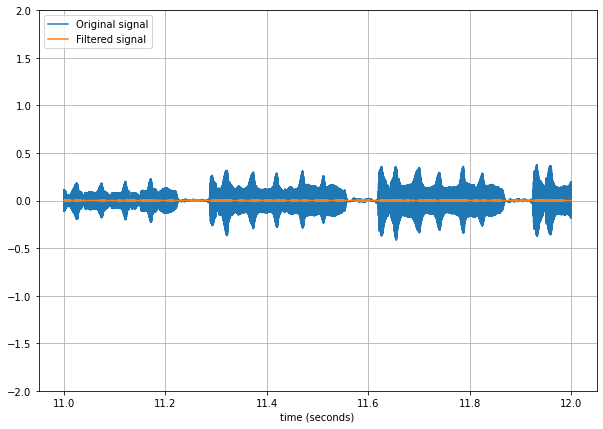

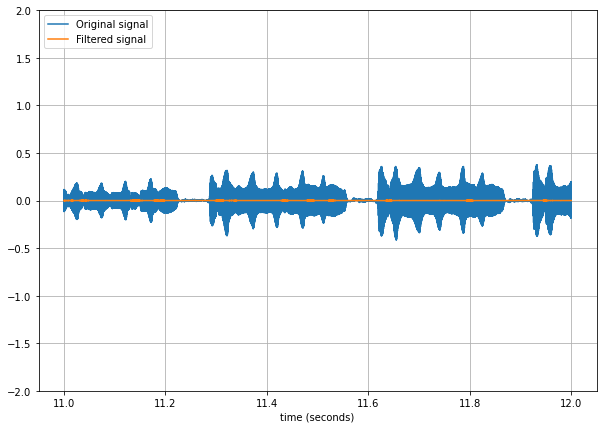

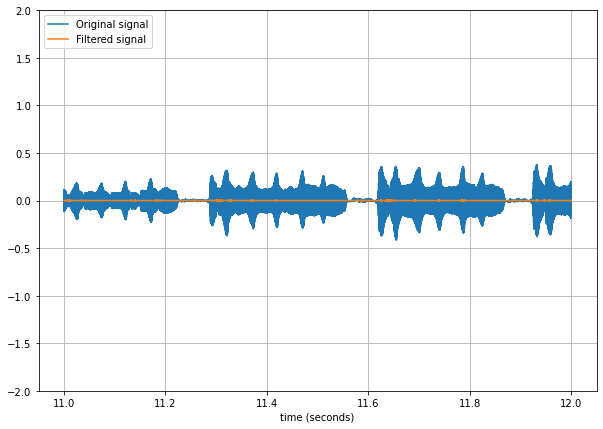

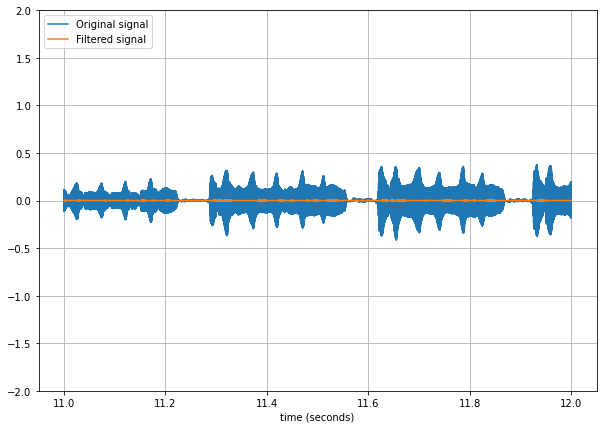

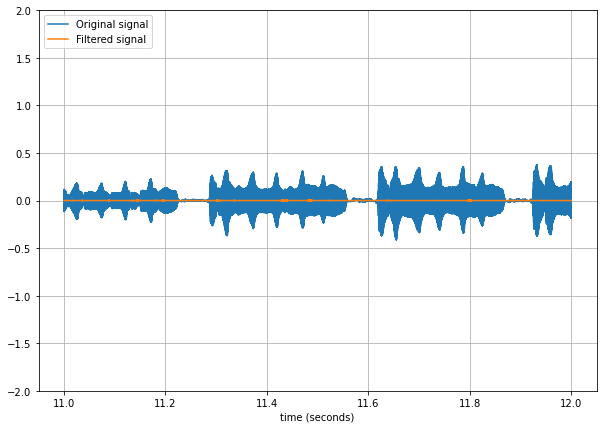

In [425]:
# timepoints for the plots
t = np.linspace(signal_start, signal_start + signal_duration, len(signal), endpoint=False)


bp_signal = []
for i in range(len(freqs)-1):
  lowcut = freqs[i]
  highcut = freqs[i+1]

  #bp_signal.append(butter_bandpass_filter(signal, lowcut, highcut, sr, order=6))
  bp_signal.append(bandpass(signal, sr, lowcut, highcut, bandwidth=50))

  plt.figure(figsize=(10,7))
  plt.clf()
  plt.plot(t, signal, label='Original signal')
  plt.plot(t, bp_signal[i], label='Filtered signal' )
  plt.xlabel('time (seconds)')
  plt.grid(True)
  plt.axis('tight')
  plt.ylim([-2,2])
  plt.legend(loc='upper left')
  plt.show()


## Get Amplitude Envelope

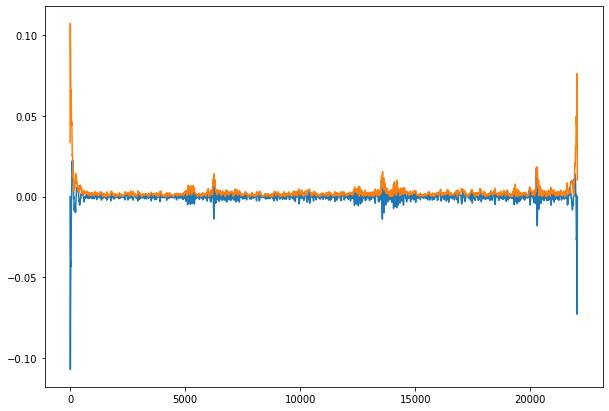

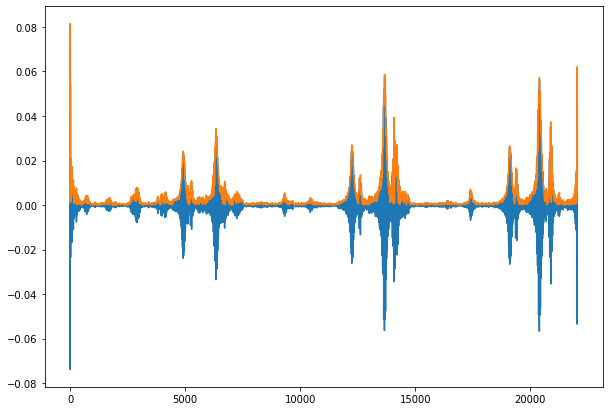

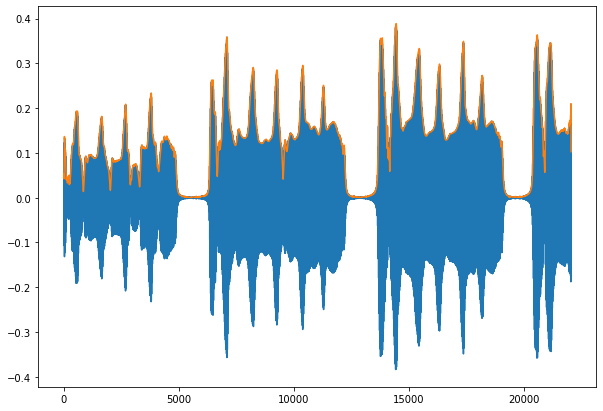

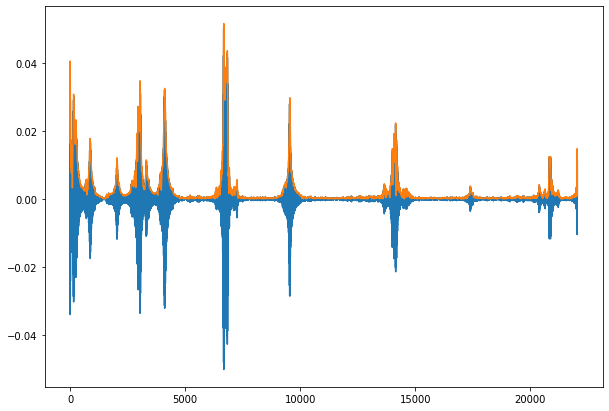

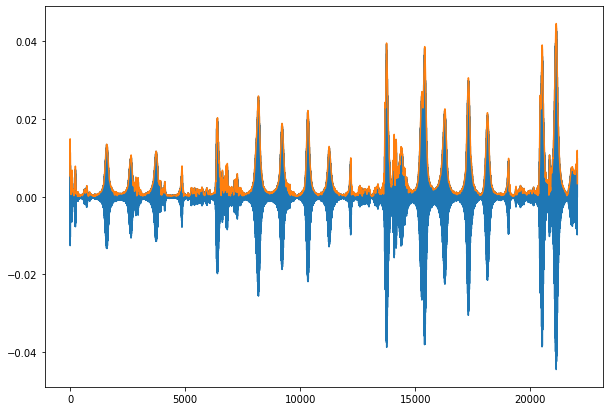

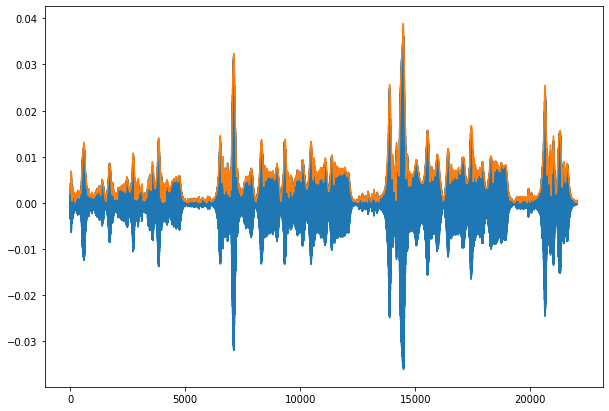

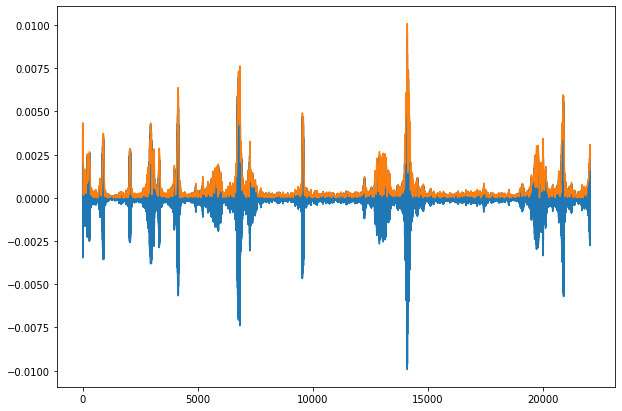

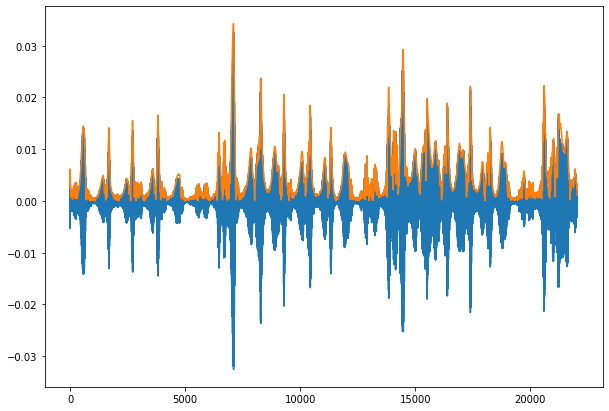

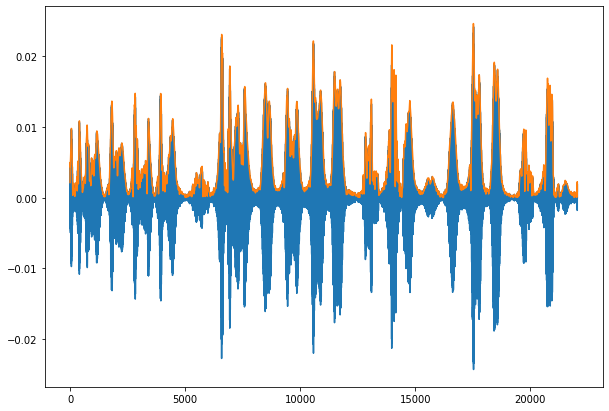

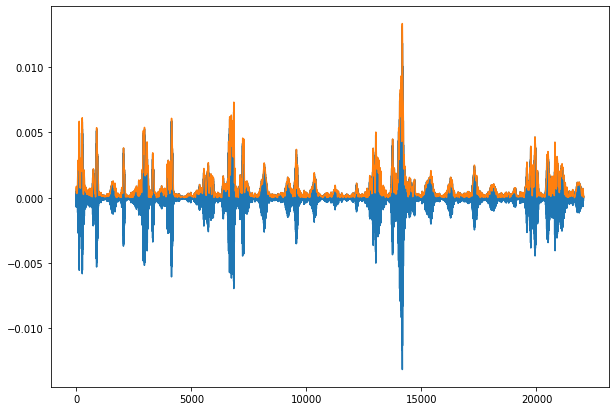

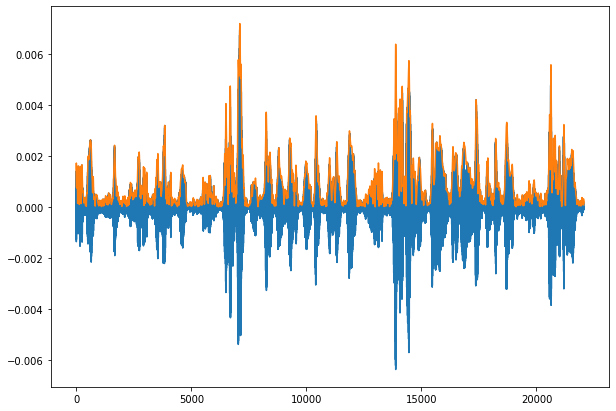

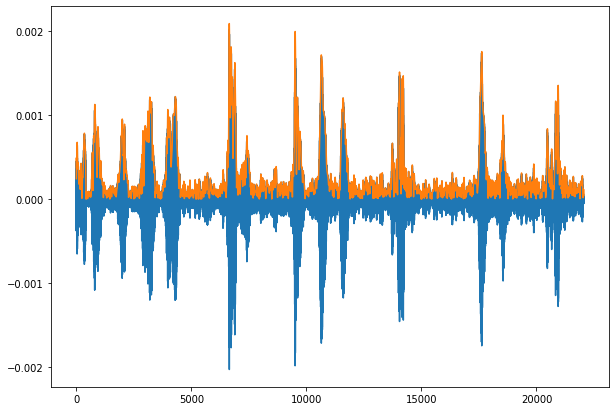

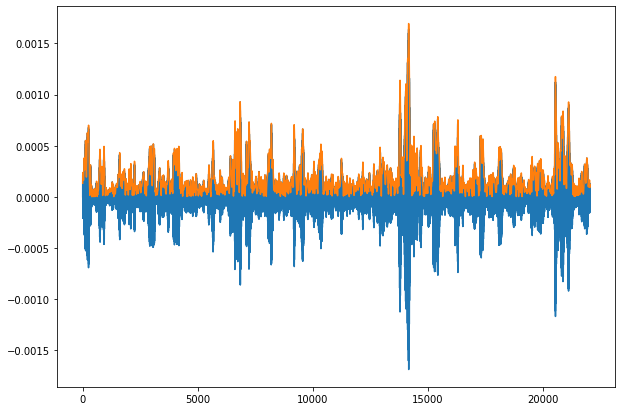

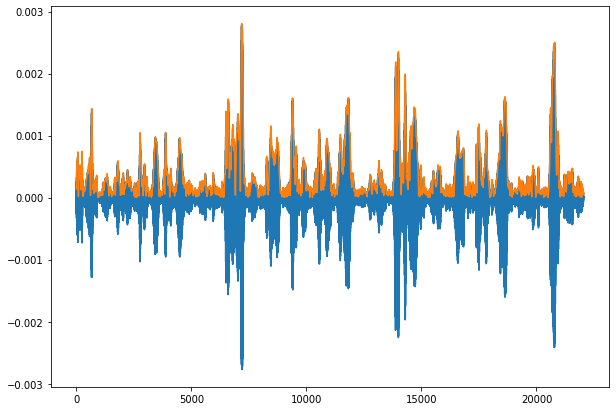

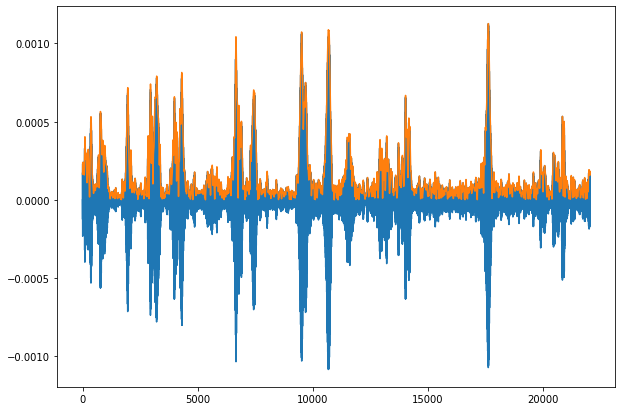

In [426]:
# get the signal A.E. using hilbert transform
amp_env = []
for s in bp_signal:
  z = (hilbert(s)) #form the analytical signal
  amp_env.append(np.abs(z)) #envelope extraction
  inst_phase = np.unwrap(np.angle(z))#inst phase
  inst_freq = np.diff(inst_phase)/(2*np.pi)*sr #inst frequency

  plt.figure(figsize=(10,7))
  plt.plot(s)
  plt.plot(amp_env[-1])
  #plt.ylim([-0.5,0.5])
  plt.show()

## Lowpass AE using FIR filter 

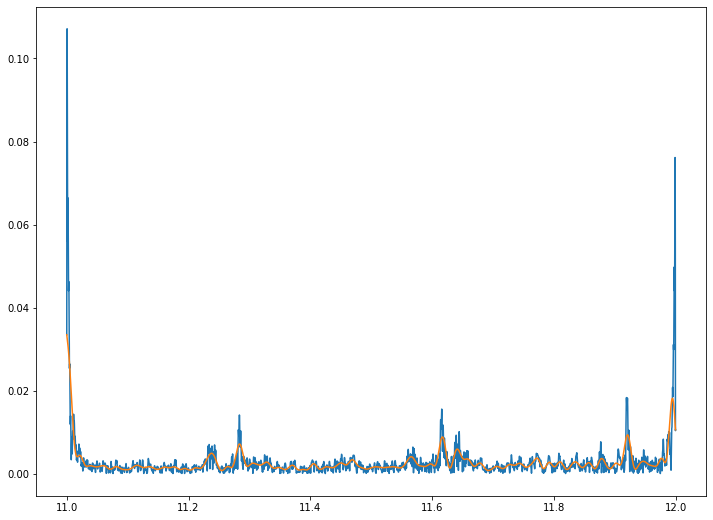

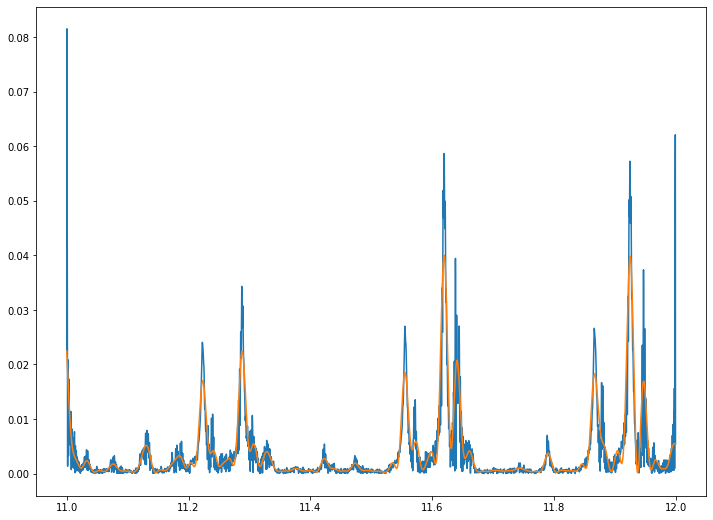

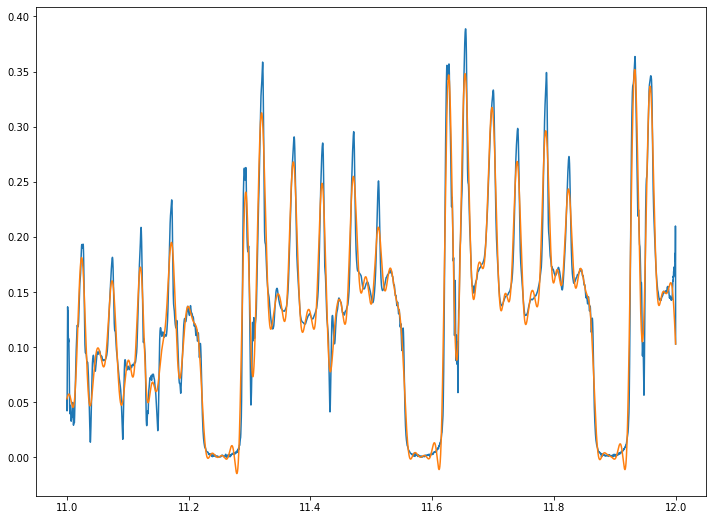

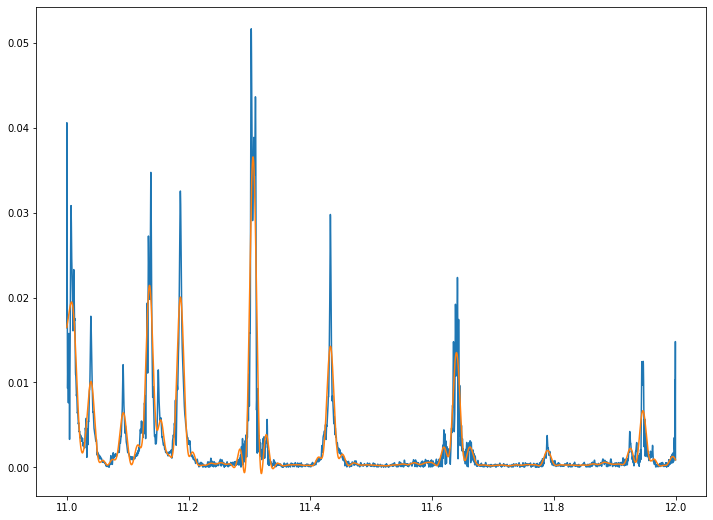

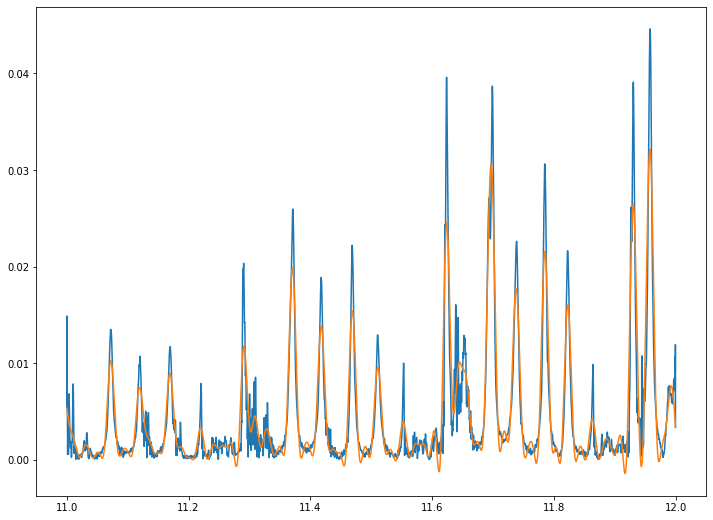

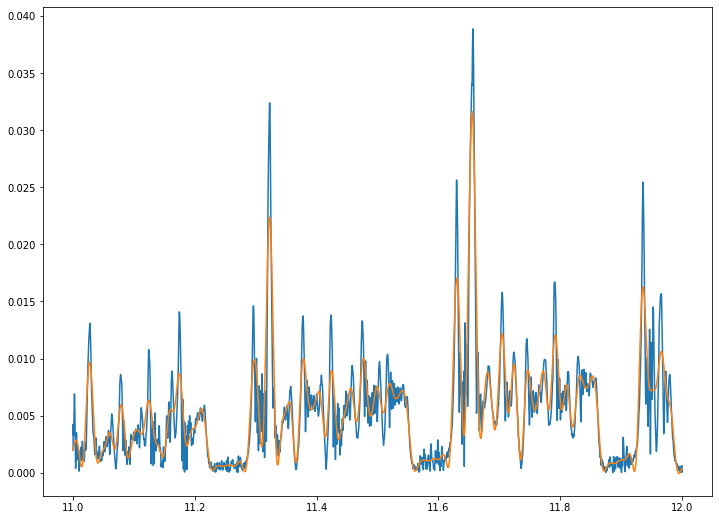

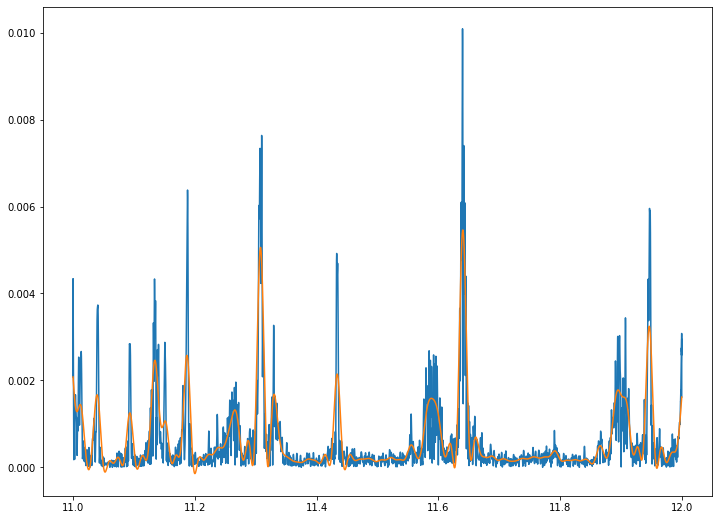

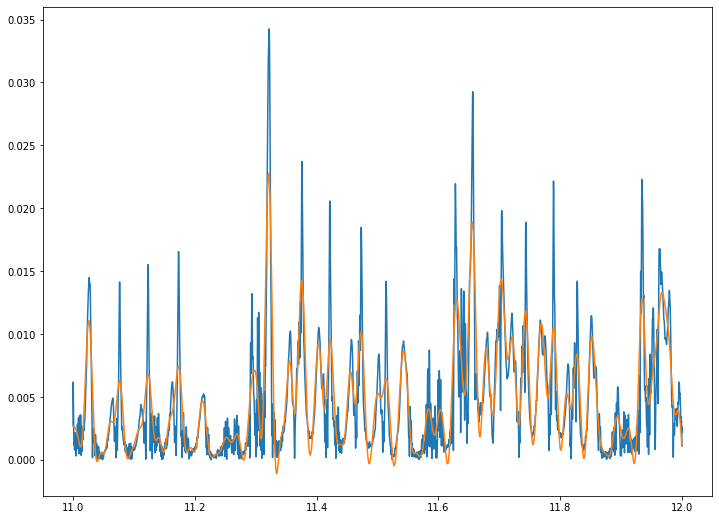

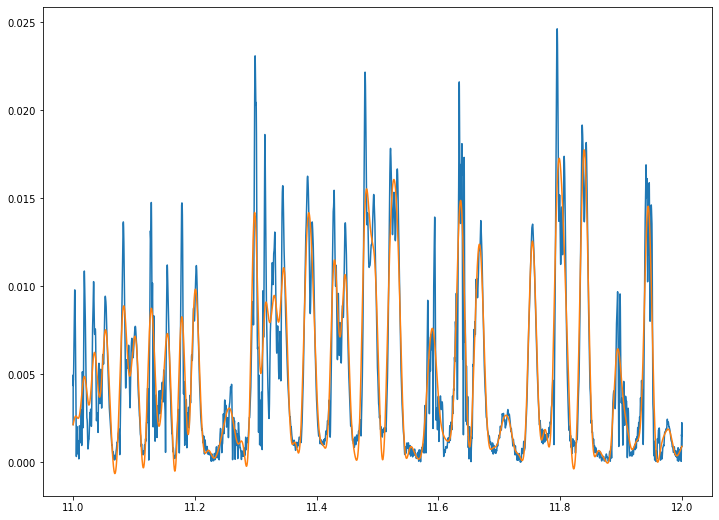

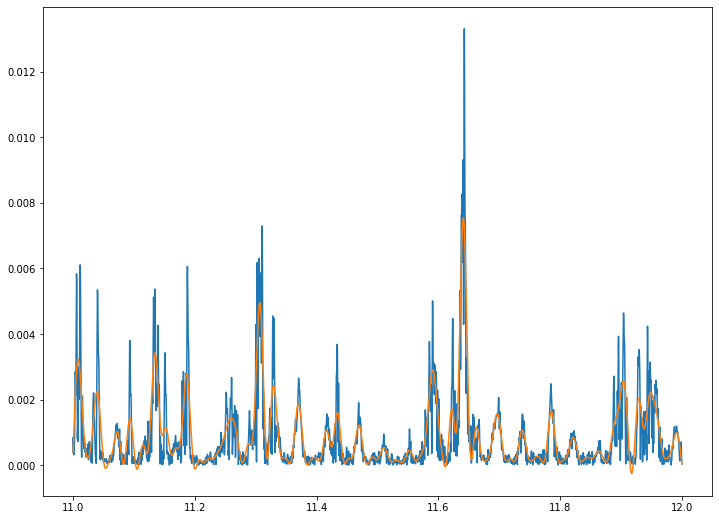

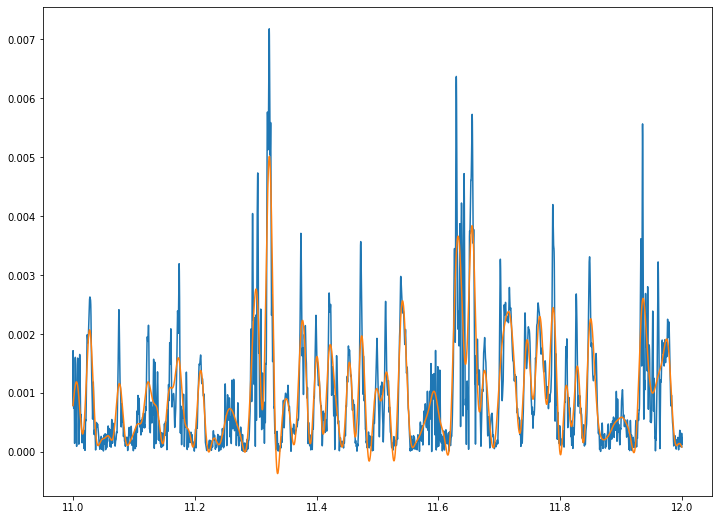

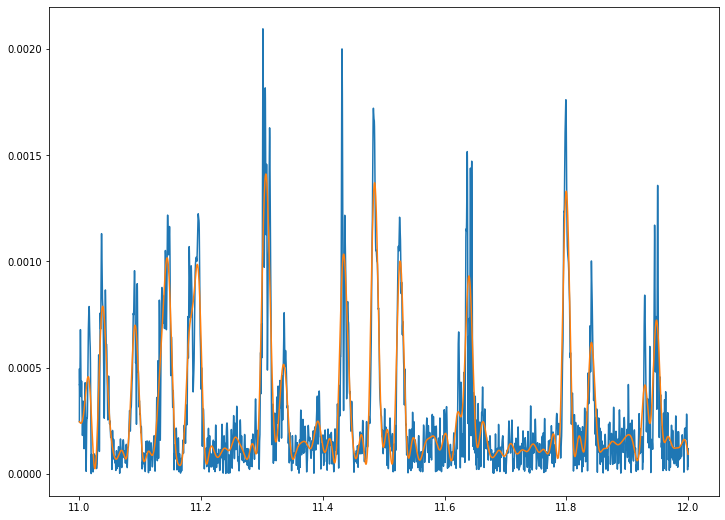

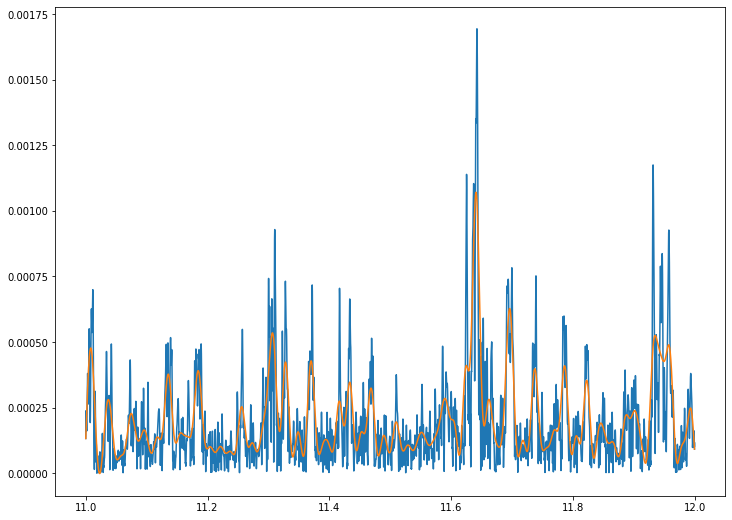

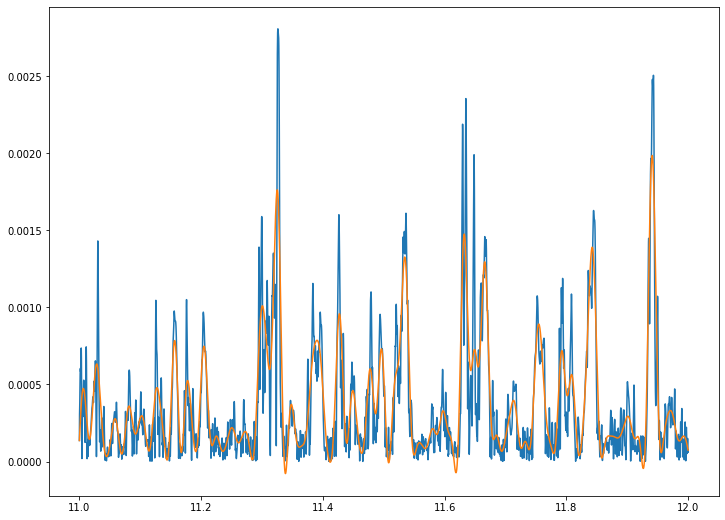

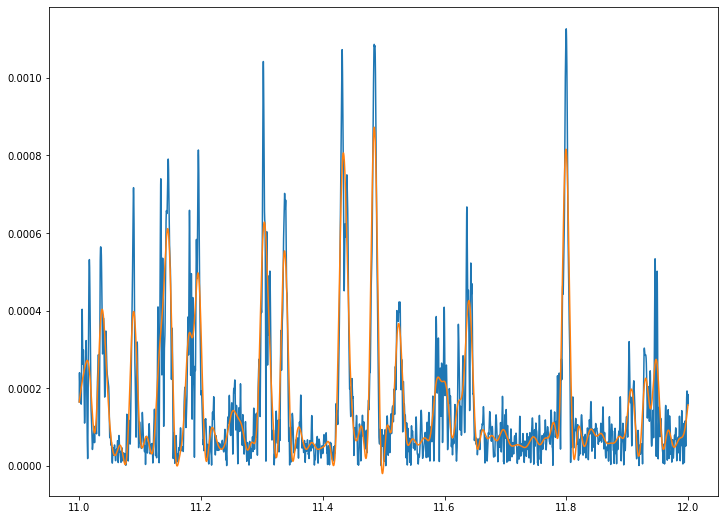

In [470]:

# cut-off frequency (upper bound)
fc=64
bandwidth=50
ripple_db=60.0

ae_lowpass=[]
for ae in amp_env:
  ae_lowpass.append(lowpass(ae, sr, fc, bandwidth,ripple_db))
  plt.figure(figsize=(12,9))
  plt.plot(t,ae)
  plt.plot(t,ae_lowpass[-1])
  plt.show()

## Modify original BP signal with new envelope

In [471]:
envR  = [i / j for i, j in zip(ae_lowpass , amp_env)]
filt_bp_signal = [ i * j for i,j in zip(bp_signal, envR)]

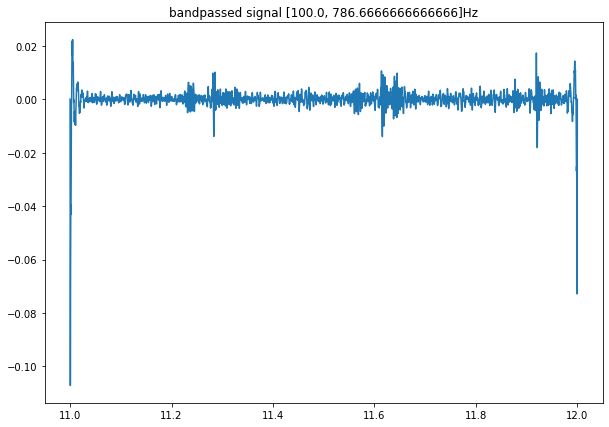

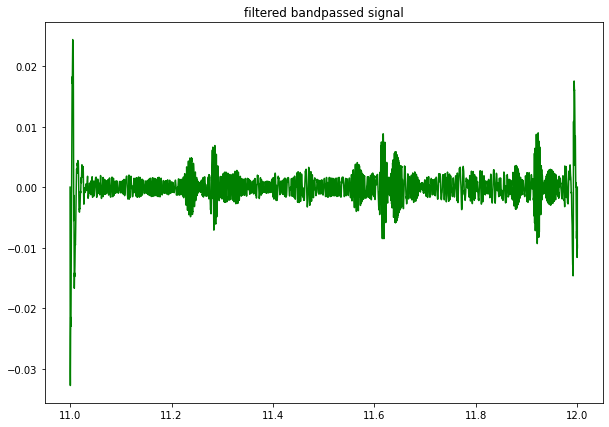

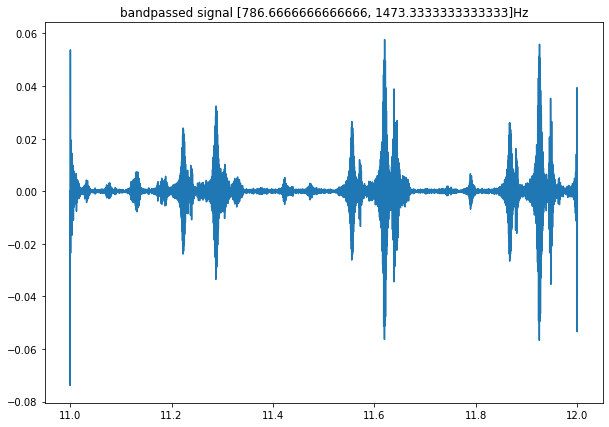

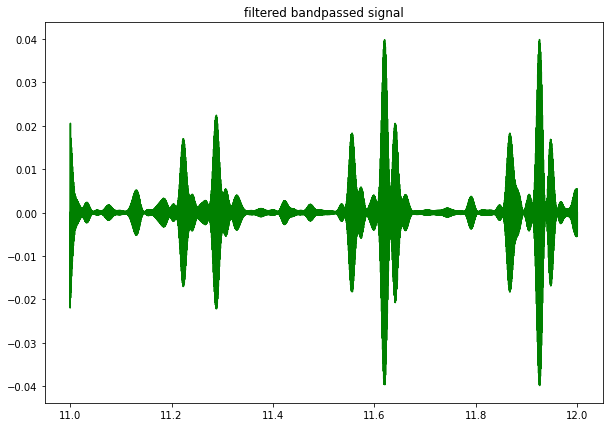

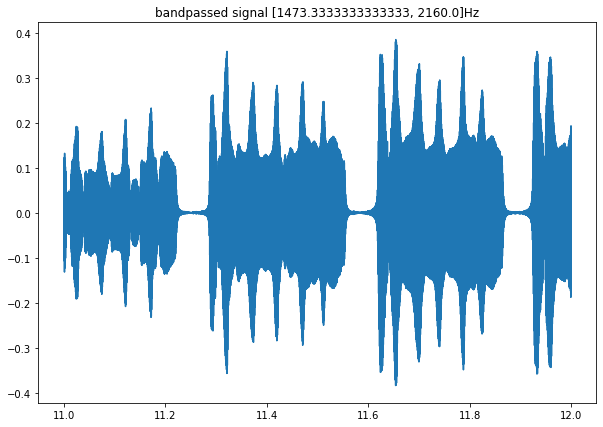

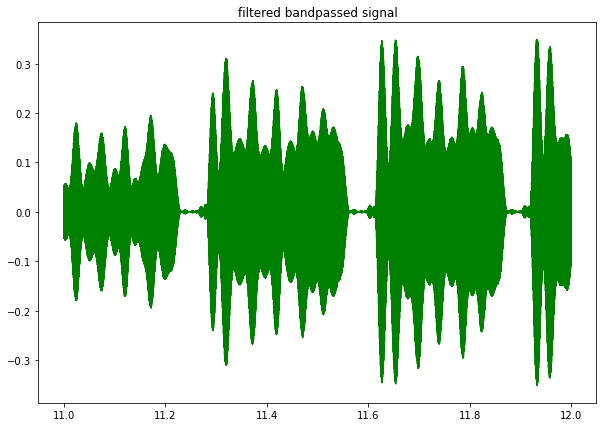

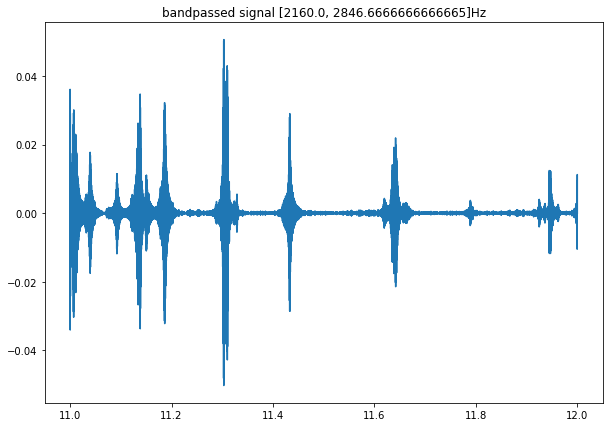

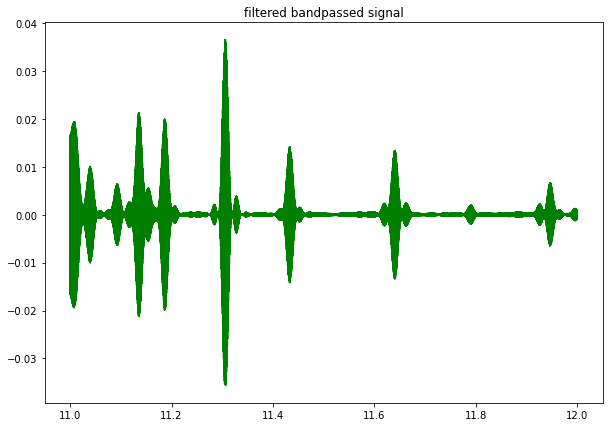

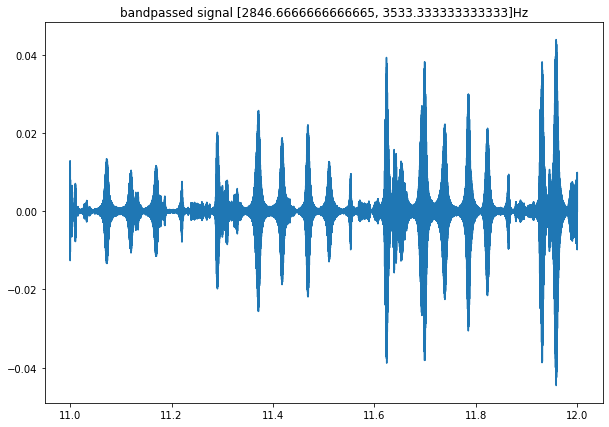

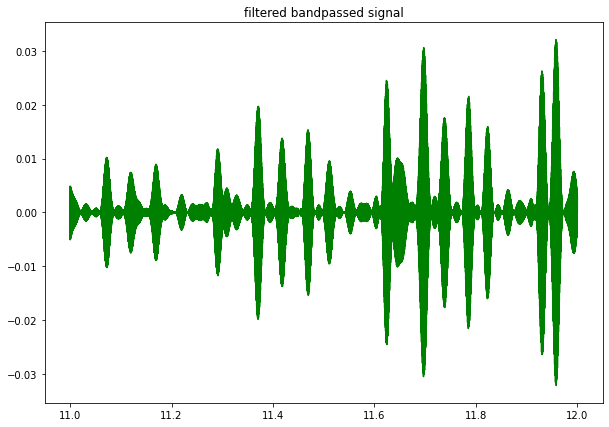

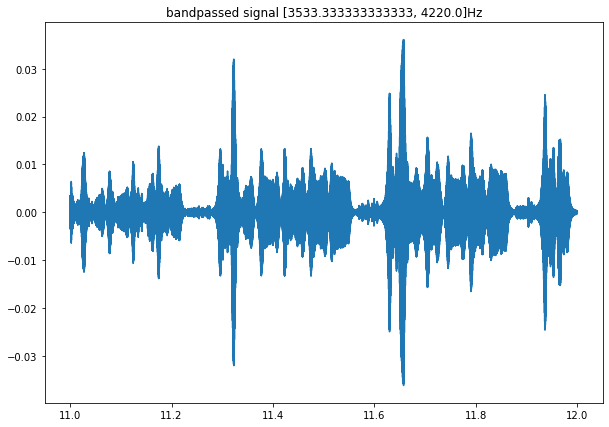

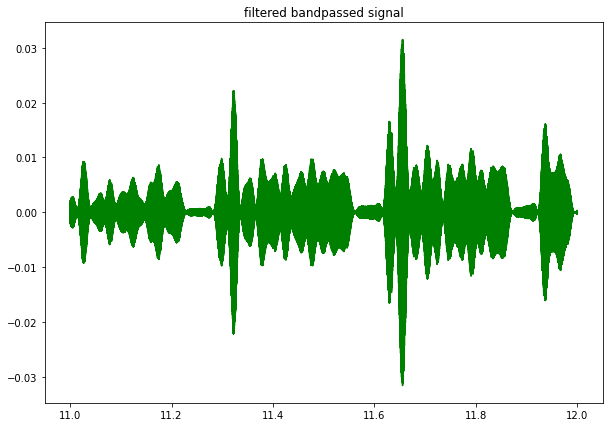

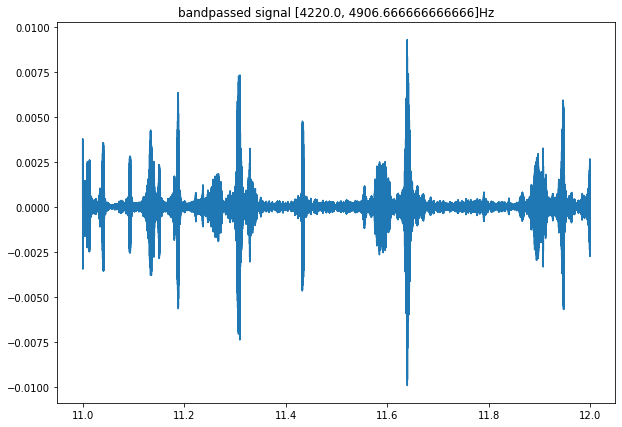

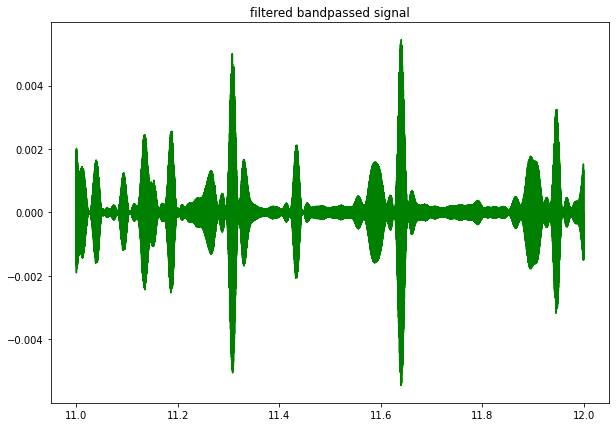

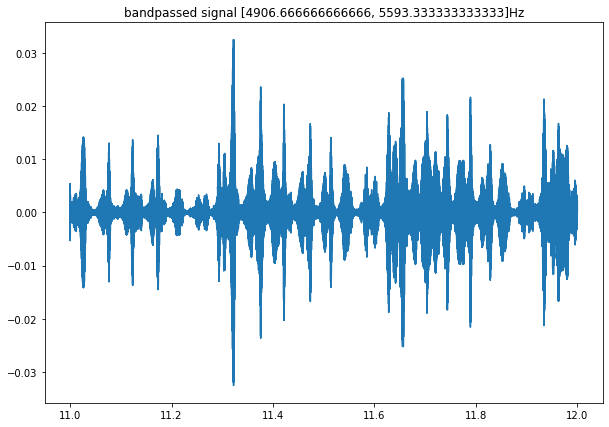

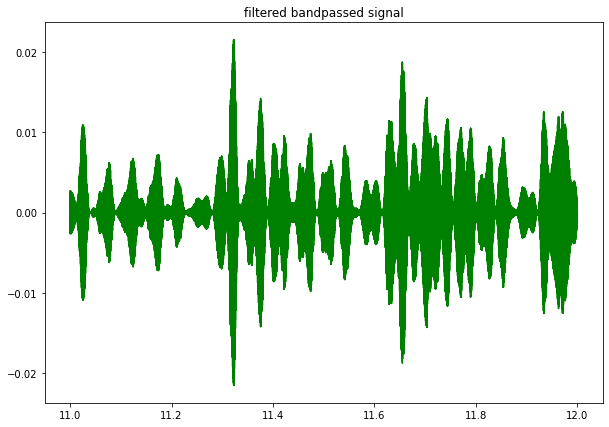

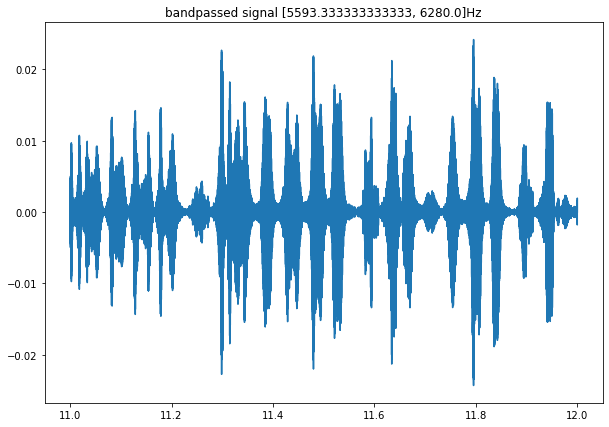

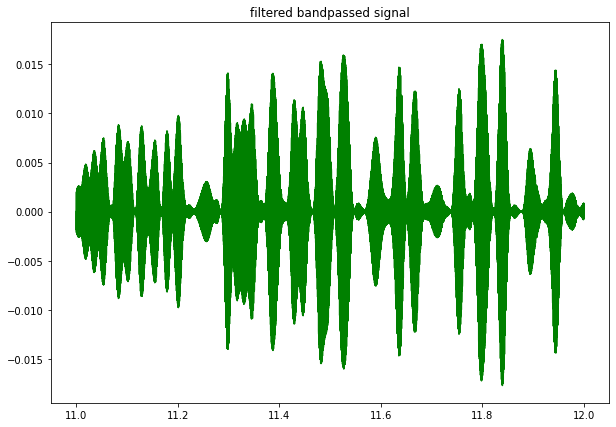

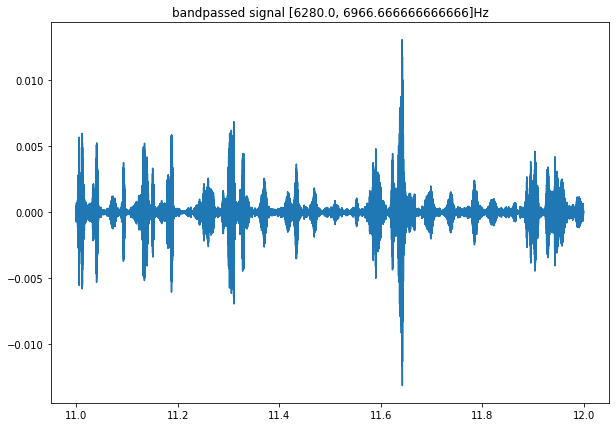

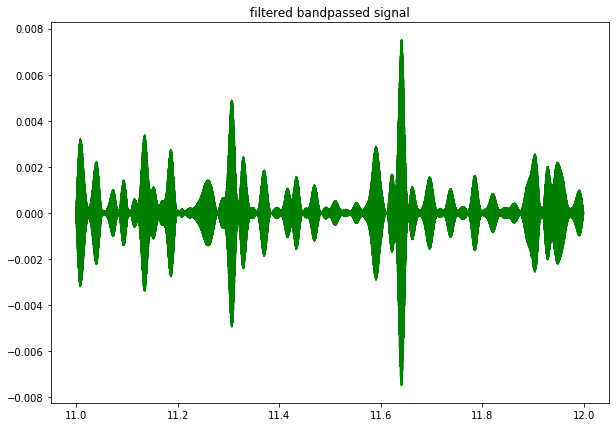

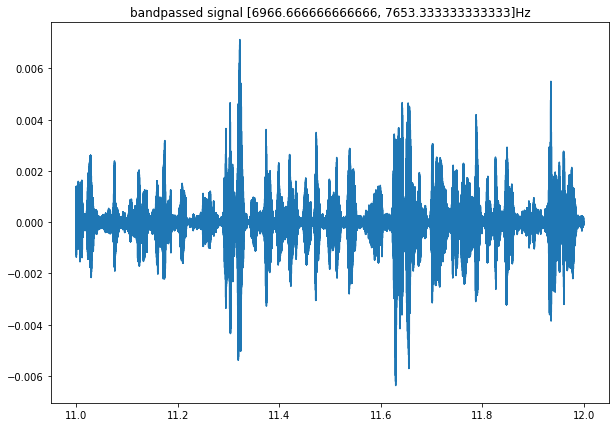

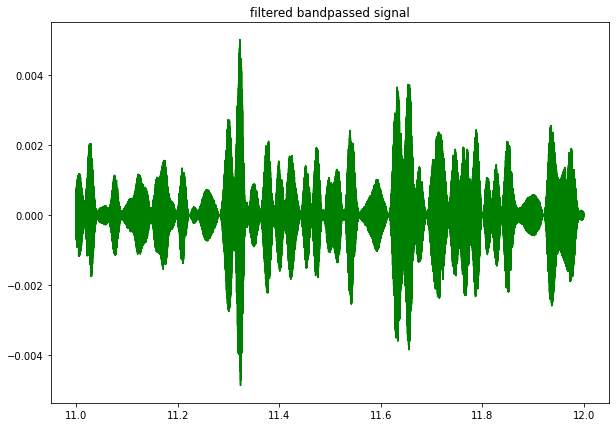

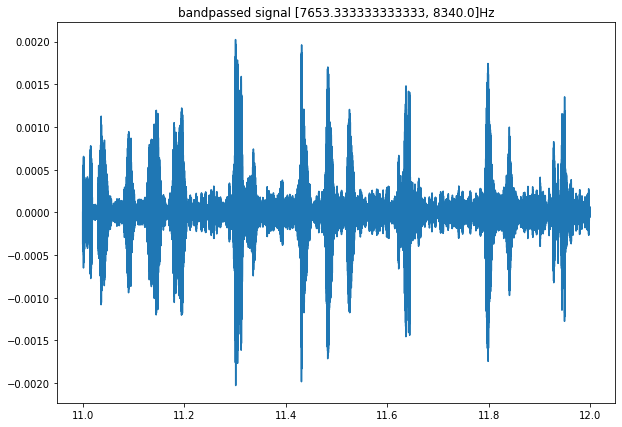

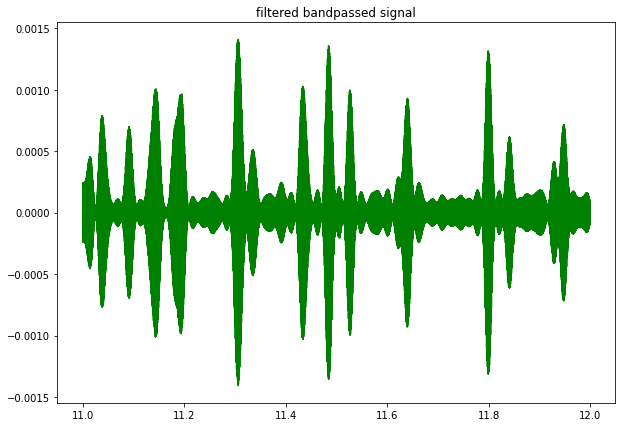

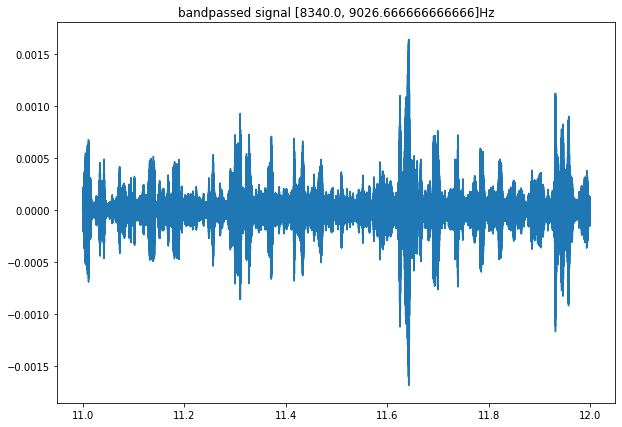

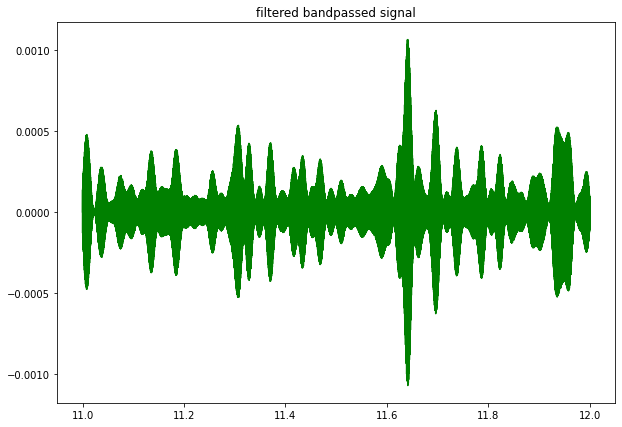

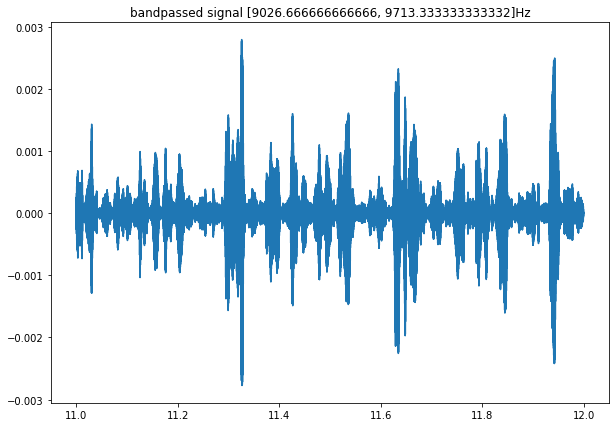

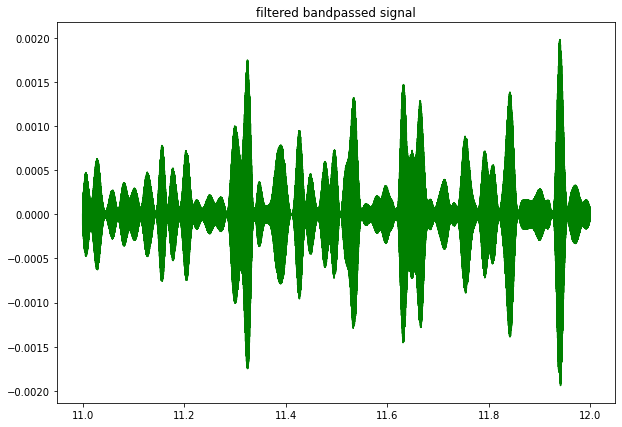

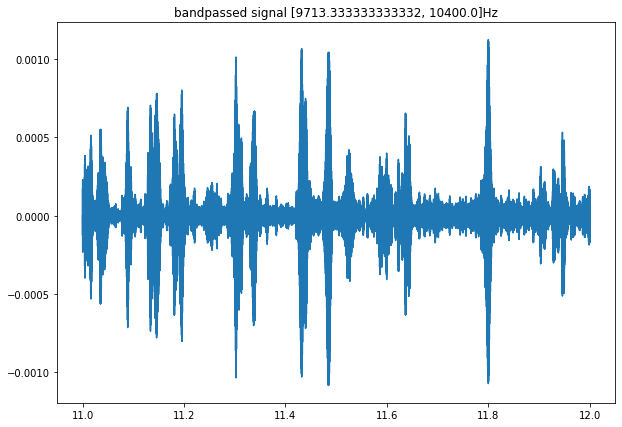

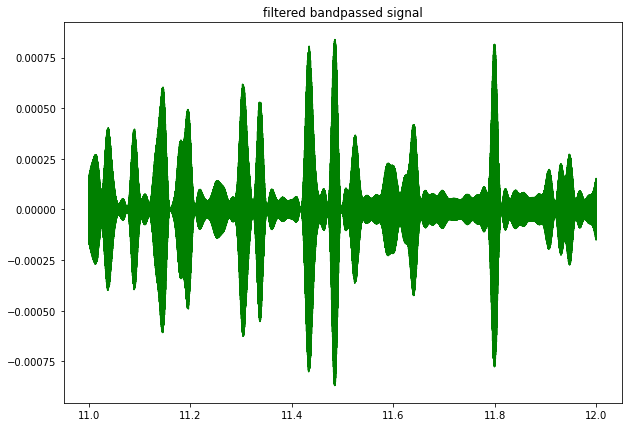

In [472]:

for i in range(len(filt_bp_signal)):
  
  plt.figure(figsize=(10,7))
  plt.figure(1)
  plt.title(f'bandpassed signal {[freqs[i] , freqs[i+1]]}Hz')
  plt.plot(t,bp_signal[i])
  plt.figure(figsize=(10,7))
  plt.figure(2)
  plt.title('filtered bandpassed signal')
  plt.plot(t,filt_bp_signal[i],c='g')
  plt.show()


## Lowpass modified signals 

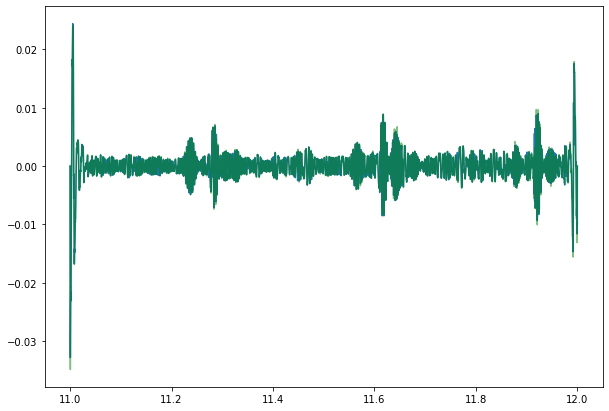

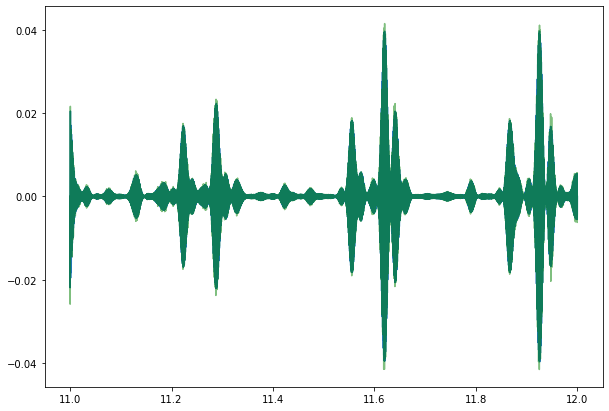

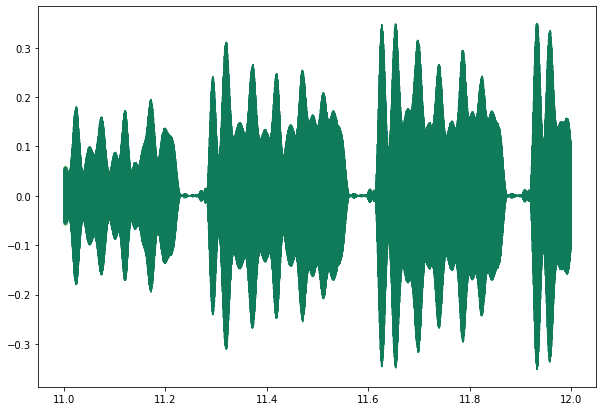

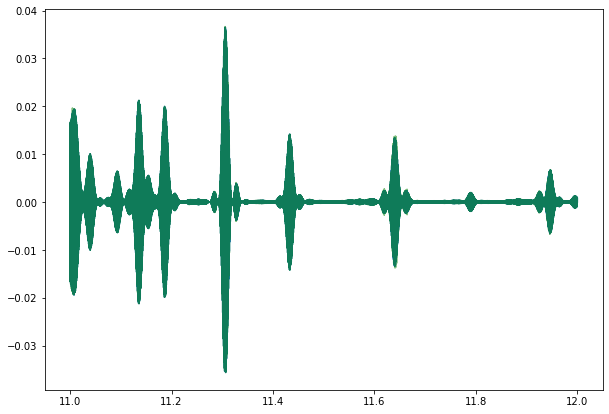

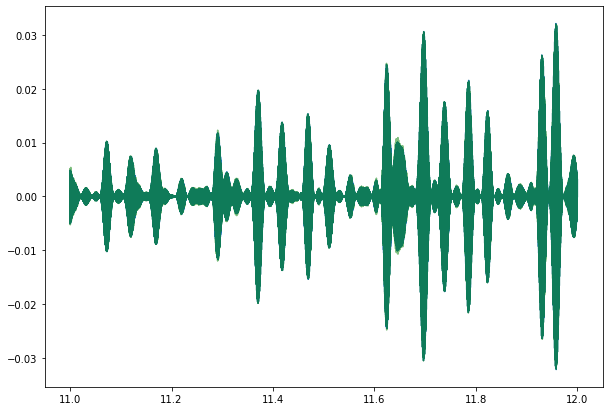

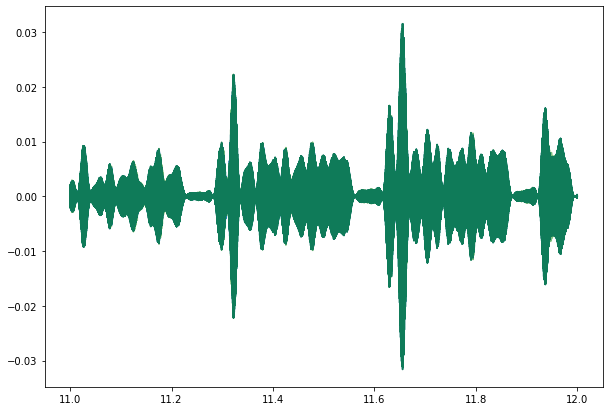

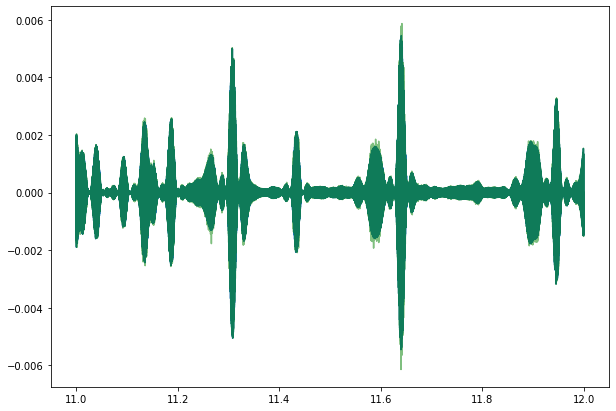

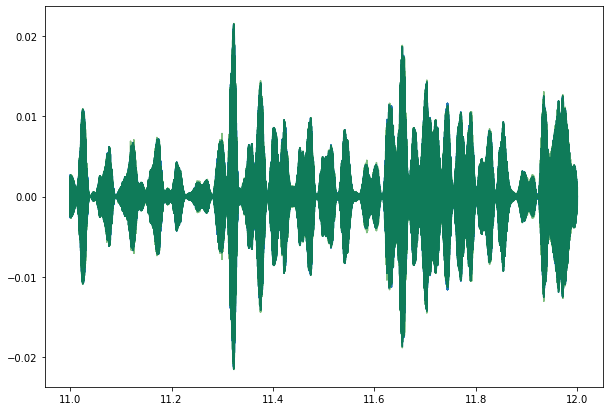

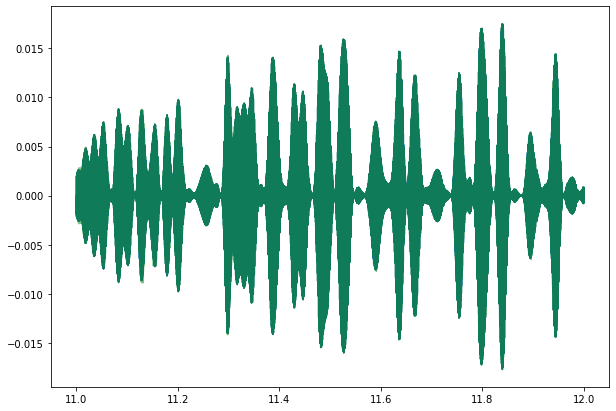

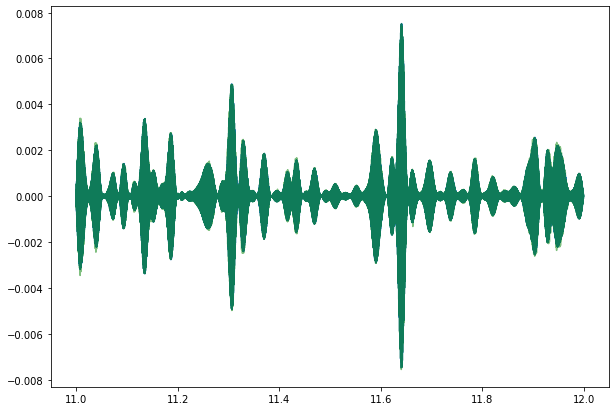

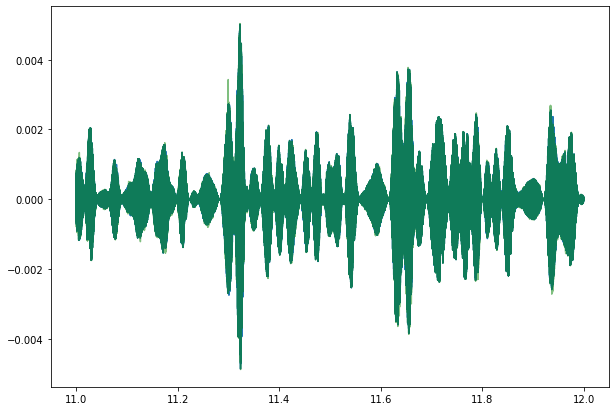

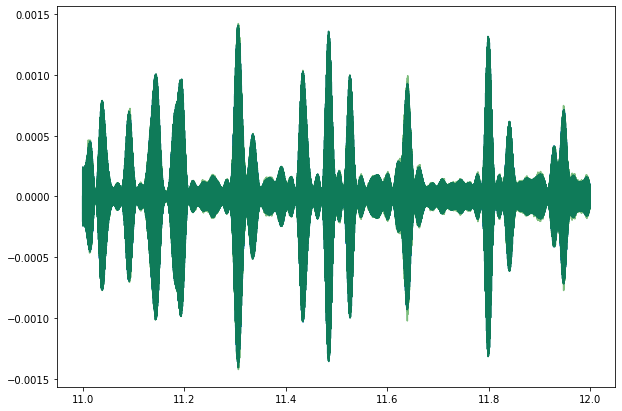

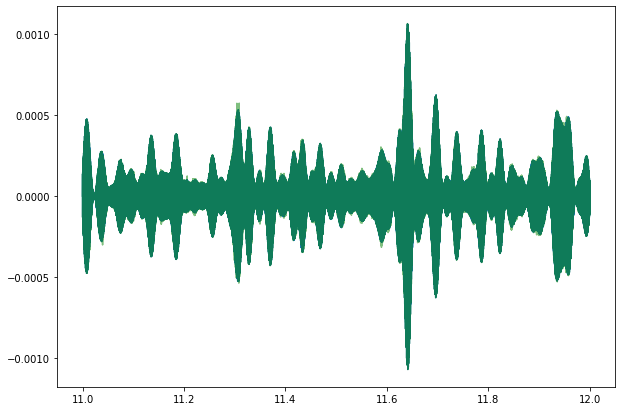

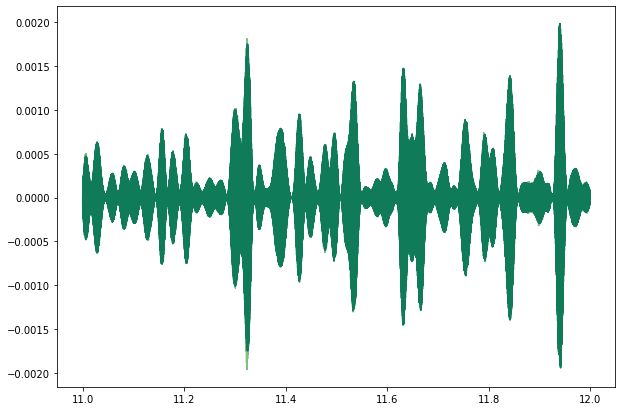

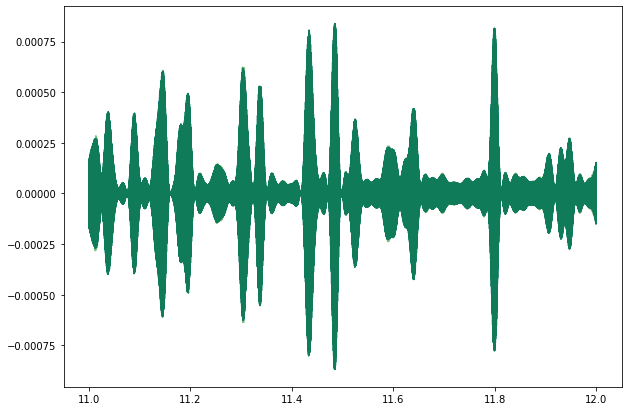

In [474]:
lp_filt_bp_signal = []
bandwidth=50
ripple_db=60

for i in range(len(filt_bp_signal)):
  fc=freqs[i+1]*1.05
  lp_filt_bp_signal.append(lowpass(filt_bp_signal[i], sr, fc, bandwidth,ripple_db))

  plt.figure(figsize=(10,7))
  plt.plot(t,filt_bp_signal[i])
  plt.plot(t,lp_filt_bp_signal[i],c='g',alpha=0.5)
  plt.show()

## Sum all modified bandpass signals

In [476]:
mod_signal=sum(lp_filt_bp_signal)

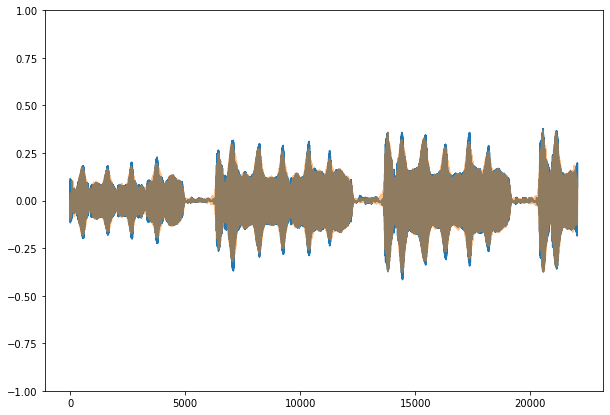

In [477]:
plt.figure(figsize=(10,7))
plt.plot(signal)
plt.plot(mod_signal,alpha=0.5)
plt.ylim([-1,1])
plt.show()

## Compare modulation spectrograms

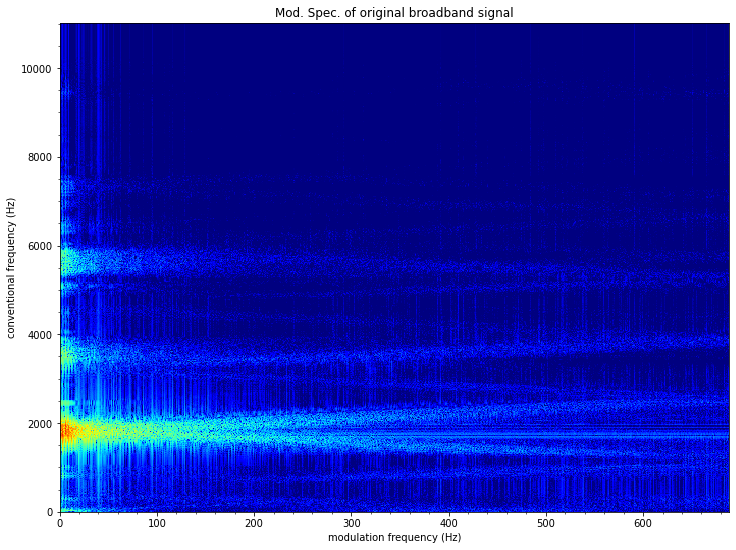

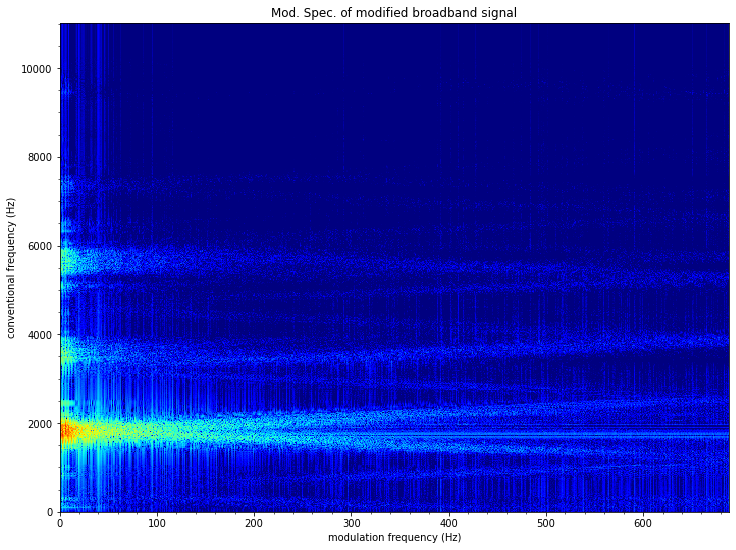

In [478]:
window_size = 1024
window_shift = 16

#Original signal
ama_input = signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


plt.figure(figsize=(12,9))
ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])
plt.title('Mod. Spec. of original broadband signal')
plt.show()


# Modified signal

ama_input = mod_signal

rfft_mod = ama.strfft_modulation_spectrogram(ama_input,
                                             sr,
                                             window_size,
                                             window_shift,
                                             channel_names=' ',
                                             win_function_y='boxcar',
                                             win_function_x='boxcar')


plt.figure(figsize=(12,9))
ama.plot_modulation_spectrogram_data(rfft_mod, c_map='jet')#,modf_range=[1,40])
plt.title('Mod. Spec. of modified broadband signal')

plt.show()

In [479]:
print('ORIGINAL AUDIO CLIP')

Audio(data=signal,rate=sr)



ORIGINAL AUDIO CLIP


In [480]:
print('MODIFIED AUDIO CLIP')

Audio(data=mod_signal,rate=sr)

MODIFIED AUDIO CLIP


In [436]:
ss=np.abs(mod_signal)**2
rms=np.sqrt(np.mean(ss))

In [437]:
rms

0.1002926809101059